In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [122]:
class GAN(object):
    
    def __init__(self, n_z, input_size, hidden_gen, hidden_dis, lr):
        self.n_z = n_z
        self.input_size = input_size
        self.hidden_gen = hidden_gen
        self.hidden_dis = hidden_dis
        self.lr = lr
        
    def generator(self, in_z, hidden_n, output_dim, reuse=False):
        with tf.variable_scope("generator", reuse=reuse):
            self.hidden_1 = tf.layers.dense(in_z, hidden_n)
            self.elu_1 = tf.nn.elu(self.hidden_1)
            print ("Generator: self.elu_1 size: ", self.elu_1.get_shape())
            
            self.logits_gen = tf.layers.dense(self.elu_1, output_dim)
            self.tanh_out = tf.nn.tanh(self.logits_gen)
            
        return self.logits_gen, self.tanh_out
    
    def discriminator(self, inp, hidden_n, output_dim, reuse=False):
        with tf.variable_scope("discriminator", reuse=reuse):
            self.hidden_1 = tf.layers.dense(inp, hidden_n)
            self.elu_1 = tf.nn.elu(self.hidden_1)
            print ("Discriminator: self.elu_1 size: ", self.elu_1.get_shape())
            
            self.logits_dis = tf.layers.dense(self.elu_1, output_dim)
            self.sigmoid_out = tf.nn.sigmoid(self.logits_dis)
            
        return self.logits_dis, self.sigmoid_out
    
    def inputs(self):
        self.z = tf.placeholder(tf.float32, [None, self.n_z], name="input_z")
        self.X = tf.placeholder(tf.float32, [None, self.input_size], name="input_X")
    
    def model(self):
        self.gen_logits, self.gen_out = self.generator(self.z, self.hidden_gen, self.input_size, reuse=False)
        self.dis_r_logits, self.dis_r_out = self.discriminator(self.X, self.hidden_dis, 1, reuse=False)
        self.dis_f_logits, self.dis_f_out = self.discriminator(self.gen_out, self.hidden_dis, 1, reuse=True)
    
    def loss(self):
        smooth = 0.1
        real_labels = tf.ones_like(self.dis_r_logits) * (1 - smooth)
        fake_labels = tf.zeros_like(self.dis_f_logits)
        
        ce_with_sigmoid = tf.nn.sigmoid_cross_entropy_with_logits
        
        self.dis_r_loss = ce_with_sigmoid(labels=real_labels, logits=self.dis_r_logits)
        self.dis_f_loss = ce_with_sigmoid(labels=fake_labels, logits=self.dis_f_logits)
        self.dis_loss = tf.reduce_mean(self.dis_r_loss + self.dis_f_loss)
        
        self.gen_loss = tf.reduce_mean(ce_with_sigmoid(labels=tf.ones_like(self.dis_f_logits),
                                                       logits=self.dis_f_logits))

    def optimize(self):
        t_vars = tf.trainable_variables()
        gen_vars = [v for v in t_vars if v.name.startswith("generator")]
        dis_vars = [v for v in t_vars if v.name.startswith("discriminator")]
        
        self.dis_opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.dis_loss, var_list=dis_vars)
        self.gen_opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.gen_loss, var_list=gen_vars)
        
    def train(self):
        self.inputs()
        self.model()
        self.loss()
        self.optimize()
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        epochs = 10
        batch_size = 100
        images_data = mnist.train.images
        z_data = np.random.uniform(-1, 1, size=(len(images_data), self.n_z))
        #z_data = np.random.normal(0, 1, size=(len(images_data), self.n_z))
        
        for epoch in range(epochs):
            for ii in range(mnist.train.num_examples//batch_size):
                batch_images = images_data[ii*batch_size: (ii+1)*batch_size]                
                #batch_images = batch[0].reshape((batch_size, self.input_size))
                batch_images = batch_images*2 - 1
                
                #batch_z = np.random.uniform(-1, 1, size=(batch_size, self.n_z))
                batch_z = z_data[ii*batch_size: (ii+1)*batch_size]
                
                self.sess.run(self.dis_opt, feed_dict={
                        self.X: batch_images,
                        self.z: batch_z
                    })
                self.sess.run(self.gen_opt, feed_dict={
                        self.z: batch_z
                    })
            
            dis_loss = self.sess.run(self.dis_loss, feed_dict={
                    self.X: batch_images,
                    self.z: batch_z
                })
            
            gen_loss = self.sess.run(self.gen_loss, feed_dict={
                    self.z:batch_z
                })
            print("Epoch: {} Discriminator Loss: {:.4f} Generator Loss: {:.4f}"
                  .format(epoch, dis_loss, gen_loss))
                
    def generate(self):
        z = np.random.uniform(-1, 1, size=(1, self.n_z))
        #z = np.random.normal(0, 1, size=(1, self.n_z))
        out_img = self.sess.run(self.gen_out, feed_dict={
                self.z: z
            })
        return out_img

In [123]:
tf.reset_default_graph()

model = GAN(n_z=100, input_size=784, hidden_gen=128, hidden_dis=128, lr=0.0005)
model.train()

('Generator: self.elu_1 size: ', TensorShape([Dimension(None), Dimension(128)]))
('Discriminator: self.elu_1 size: ', TensorShape([Dimension(None), Dimension(128)]))
('Discriminator: self.elu_1 size: ', TensorShape([Dimension(None), Dimension(128)]))
Epoch: 0 Discriminator Loss: 0.5629 Generator Loss: 1.6029
Epoch: 1 Discriminator Loss: 0.5514 Generator Loss: 3.5705
Epoch: 2 Discriminator Loss: 0.5904 Generator Loss: 3.1679
Epoch: 3 Discriminator Loss: 0.4927 Generator Loss: 3.5778
Epoch: 4 Discriminator Loss: 0.6680 Generator Loss: 2.6250
Epoch: 5 Discriminator Loss: 0.8415 Generator Loss: 1.8671
Epoch: 6 Discriminator Loss: 0.8551 Generator Loss: 1.7656
Epoch: 7 Discriminator Loss: 0.8793 Generator Loss: 2.0554
Epoch: 8 Discriminator Loss: 1.5531 Generator Loss: 0.8924
Epoch: 9 Discriminator Loss: 1.5078 Generator Loss: 1.6196


In [124]:
img = model.generate()

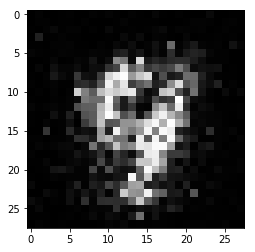

In [125]:
plt.imshow(img.reshape((28, 28)), cmap="Greys_r")

In [126]:
print mnist.train.images.shape

(55000, 784)


In [203]:
tf.reset_default_graph()

In [207]:
class DCGAN(GAN):
    
    def __init__(self, n_z, input_size, hidden_gen, hidden_dis, lr):
        GAN.__init__(self, n_z, input_size, hidden_gen, hidden_dis, lr)
        
    def generator(self, z, reuse=False):
        with tf.variable_scope("generator", reuse=reuse):
            #z = tf.reshape(inp, [-1, 10, 10, 1])
            #print ("Generator: inp size: ", inp.get_shape())
            z_pro = tf.layers.dense(z, 7*7)
            z_re = tf.reshape(z_pro, [-1, 7, 7, 1])
            
            self.conv2d_t_1 = tf.layers.conv2d_transpose(z_re, 10, (5,5), 2, padding='same', name='conv_t_1')
            self.relu_1 = tf.nn.relu(self.conv2d_t_1)
            print ("Generator: self.relu_1 size: ", self.relu_1.get_shape())
            
            self.conv2d_t_2 = tf.layers.conv2d_transpose(self.relu_1, 10, (5,5), 2, padding='same', name='conv_t_2')
            self.relu_2 = tf.nn.relu(self.conv2d_t_2)
            print ("Generator: self.relu_2 size: ", self.relu_2.get_shape())
            
            self.conv2d_t_3 = tf.layers.conv2d_transpose(self.relu_2, 1, (5,5), 1, padding='same', name='conv_t_3')
            print ("Generator: self.conv2d_t_3 size: ", self.conv2d_t_3.get_shape())
            self.tanh_out = tf.contrib.layers.flatten(tf.nn.tanh(self.conv2d_t_3))
            
        return tf.contrib.layers.flatten(self.conv2d_t_3), self.tanh_out
            
    def model(self):
        self.gen_logits, self.gen_out = self.generator(self.z, reuse=False)
        self.dis_r_logits, self.dis_r_out = self.discriminator(self.X, self.hidden_dis, 1, reuse=False)
        self.dis_f_logits, self.dis_f_out = self.discriminator(self.gen_out, self.hidden_dis, 1, reuse=True)
        
    def inputs(self):
        self.z = tf.placeholder(tf.float32, [None, self.n_z], name="input_z")
        self.X = tf.placeholder(tf.float32, [None, self.input_size], name="input_X")

In [208]:
tf.reset_default_graph()
model = DCGAN(n_z=100, input_size=784, hidden_gen=128, hidden_dis=128, lr=0.0005)

In [209]:
model.train()

('Generator: self.relu_1 size: ', TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(10)]))
('Generator: self.relu_2 size: ', TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(10)]))
('Generator: self.conv2d_t_3 size: ', TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)]))
('Discriminator: self.elu_1 size: ', TensorShape([Dimension(None), Dimension(128)]))
('Discriminator: self.elu_1 size: ', TensorShape([Dimension(None), Dimension(128)]))
Epoch: 0 Discriminator Loss: 0.5755 Generator Loss: 2.1580
Epoch: 1 Discriminator Loss: 0.4412 Generator Loss: 2.5295
Epoch: 2 Discriminator Loss: 1.0408 Generator Loss: 1.0605
Epoch: 3 Discriminator Loss: 1.2566 Generator Loss: 0.9942
Epoch: 4 Discriminator Loss: 1.3674 Generator Loss: 0.8773
Epoch: 5 Discriminator Loss: 1.1333 Generator Loss: 1.1555
Epoch: 6 Discriminator Loss: 1.0150 Generator Loss: 1.2293
Epoch: 7 Discriminator Loss: 1.3775 Generator Loss: 0.9109
Epoch: 8 Discriminator

In [258]:
img = model.generate()

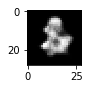

In [259]:
plt.figure(figsize=(1,1))
plt.imshow(img.reshape((28, 28)), cmap="Greys_r")